# Explore Kernel Density Estimate Fitting on WNS 'Endemic Area'

In [1]:
import os
import ipywidgets as widgets

import geopandas as gpd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
from shapely.geometry import mapping, Polygon, MultiPolygon, LineString, Point

In [2]:
wns_fname = os.path.join('data', "WNS_Status_Provisional_8_30_2018.shp")
wns = gpd.GeoDataFrame.from_file(wns_fname)
wns['year'] = wns.WNS_MAP_YR.str[:4].astype(int)

In [3]:
target_crs = {'proj': 'aea',
 'lat_1': 29.5,
 'lat_2': 45.5,
 'lat_0': 23,
 'lon_0': -96,
 'x_0': 0,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'm',
 'no_defs': True}

In [4]:
states_fname = os.path.join('data', "cb_2017_us_state_20m.shp")
states = gpd.read_file(states_fname)
states_aea = states.to_crs(target_crs)

In [5]:
centroids = wns.centroid
centroids = centroids.to_crs(target_crs)
wns['x'] = centroids.x
wns['y'] = centroids.y

# wns.head(5)

In [15]:
def reclass_as_pcnt(Z):
    uniques = np.unique(Z)[::-1]
    z_reclass = np.copy(Z)
    total_dens = Z.sum()
    cum_area = 0.0
    for u in uniques:
        cum_area += np.count_nonzero(Z==u)*u
        z_reclass[Z==u] = cum_area/total_dens
    return z_reclass
    #area_lookup[unique] = np.count_nonzero(z==unique)

def create_kernel(x, y, X, Y, factor=1.2):
    
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)#, bw_method='silverman')#, bw_method=0.15/np.asarray(values).std(ddof=1))
#     kernel.silverman_factor()
#     kernel.set_bandwidth(bw_method='silverman')
    kernel.set_bandwidth(bw_method=kernel.factor / factor)
    # kernel.set_bandwidth(bw_method=bw_method)
    # kernel.set_bandwidth(bw_method=0.15/np.asarray(values).std(ddof=1))
    Z = np.reshape(kernel(positions).T, X.shape)
    return reclass_as_pcnt(Z)

def create_kernel_contours(x, y, z, levels=[0.5, 0.75, 0.95]):
    cset = plt.contour(x, y, z, levels=levels, colors=['red', 'white', 'blue'])
    return cset



def plot_one(x, y, X, Y, Z, title='', isopleth=0.75):
    fig = plt.figure(figsize=(25, 15))
    ax = fig.add_subplot(111)

    cset = create_kernel_contours(X, Y, Z, levels=[isopleth])   
    
#     ax.imshow(np.rot90(Z), cmap=plt.cm.Reds_r, 
#                extent=[X.min(), X.max(), Y.min(), Y.max()], alpha=0.6)

    hull = Polygon(zip(x, y)).convex_hull
    pnts = np.array(np.asarray(hull.exterior)).transpose()
    
#     ax.plot(pnts[0],pnts[1])
    
#     ax.plot(x, y, 'k.', markersize=6, alpha=0.4)
#     ax.set_xlim([X.min(), X.max()])
#     ax.set_ylim([Y.min(), Y.max()])
    ax.set_xlim([-3000000, 3000000])
    ax.set_ylim([0, 3700000])
#     plt.colorbar()
    states_aea.plot(color='None',  edgecolor='black', ax=ax, alpha=0.2)
    plt.title(title,fontsize=30)
#     plt.show()
    ax.set_aspect('equal')
    return ax

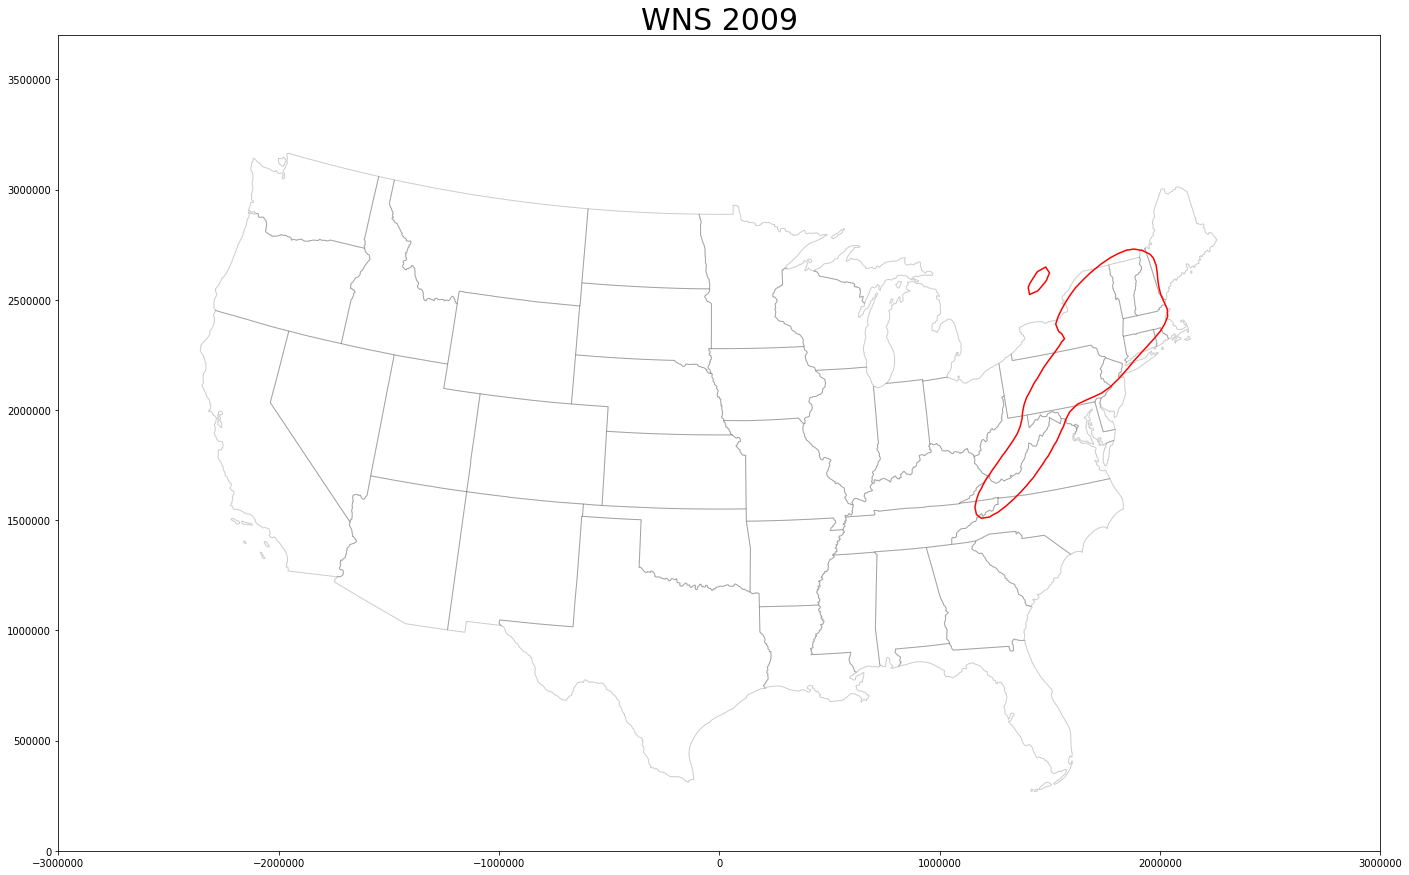

In [16]:
plt.rcParams['figure.figsize'] = [20, 20]

pad = 1000000

data = wns[wns.year <= 2009]
X, Y = np.mgrid[data.x.min()-pad:data.x.max()+pad:100j, data.y.min()-pad:data.y.max()+pad:100j]

Z = create_kernel(data.x, data.y, X, Y, factor=1.9)
# Z = create_kernel(data.x, data.y, X, Y)
# cset = create_kernel_contours(X, Y, Z, levels=[0.5, 0.75, 0.95])

ax = plot_one(data.x, data.y, X, Y, Z, title='WNS 2009')
# cm = data.to_crs(states_aea.crs).plot(column='year', cmap='plasma', ax=ax, legend=True)

In [17]:
cache = {}

def interactive_plot(factor, iso=0.75, year=2017, 
                     add_counties=False, add_centroids=True,
                     add_surface=True):
    if year in cache:
        X, Y, data = cache[year]['data']
    else:
        cache[year] = {}
        cache[year]['kernels'] = {}
        data = wns[wns.year <= year]
        
        X, Y = np.mgrid[data.x.min()-pad:data.x.max()+pad:100j, data.y.min()-pad:data.y.max()+pad:100j]
        cache[year]['data'] = (X, Y, data)
        
    if factor in cache[year]['kernels']:
        Z = cache[year]['kernels'][factor]
    else:
        Z = create_kernel(data.x, data.y, X, Y, factor)
        cache[year]['kernels'][factor] = Z
        
    ax = plot_one(data.x, data.y, X, Y, Z, isopleth=iso, title=f"WNS {year}-{year+1}")
    
    if add_surface:
        ax.imshow(np.rot90(Z), cmap=plt.cm.Reds_r, 
           extent=[X.min(), X.max(), Y.min(), Y.max()], alpha=0.6)
    
    if add_counties:
        data.to_crs(states_aea.crs).plot(column='year', cmap='plasma', ax=ax, legend=True)
    
    if add_centroids:
        data.to_crs(states_aea.crs).centroid.plot(color='grey', ax=ax)

In [18]:
f = widgets.FloatSlider(
    value=1.2,
    min=0.1,
    max=4.0,
    step=0.1,
    description="BW Factor")

In [27]:
y = widgets.IntSlider(
    value=2014,
    min=wns.year.min()+1,
    max=wns.year.max(),
    step=1,
    description="Year")

In [28]:
i = widgets.FloatSlider(
    value=0.75,
    min=0.05,
    max=.99,
    step=0.05,
    description="Isopleth")

In [29]:
c = widgets.Checkbox(value=False, description='Show Counties')
c2 = widgets.Checkbox(value=True, description='Show Centroids')
c3 = widgets.Checkbox(value=False, description='Show KDE Surface')

In [30]:
from ipywidgets import interact
_ = interact(interactive_plot, factor=f, iso=i, year=y, 
             add_counties=c,
             add_centroids=c2,
             add_surface=c3,)

interactive(children=(FloatSlider(value=0.6, description='BW Factor', max=4.0, min=0.1), FloatSlider(value=0.7…